In [76]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, TweetTokenizer 
  
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import string
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, ConfusionMatrixDisplay, confusion_matrix, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

# Notice that these vectorizers are from `sklearn` and not `nltk`!
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,HashingVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from nltk import FreqDist
from itertools import chain

import nltk
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /Users/jayiraj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/jayiraj/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jayiraj/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Business Understanding

As Data Scientists at Apple, we are attempting to leverage sentiment of tweets, particularly tweets related to Apple and Google at a SXSW (South By Southwest) event, to enhance our social media engagement, as well as our general marketing and advertising strategies. SXSW is is an annual festival/conference event held in Austin, Texas. We aim to assess our product marketing effectiveness to inform future strategies, ensuring our approach is both data-driven and responsive to consumer trends. This analysis will help us identify areas of improvement in our products and services, as well as opportunities for innovation.

By proactively addressing these concerns, we can demonstrate our commitment to customer satisfaction and product improvement. Additionally, we will be able to spot emerging trends and topics in real-time, allowing us to engage with our audience more effectively and participate in relevant conversations. 

# Data Understanding

The data we are using was taken from [data.world](https://data.world/crowdflower/brands-and-product-emotions/workspace/file?filename=judge-1377884607_tweet_product_company.csv). It contains 9,093 tweets that mention SXSW and mention different companies and/or its products. Each row represents a tweet, and there are three columns: one dispaying the tweet text itself, one that labels the product or company the sentiment in the tweet is directed at, and one that tells us whether the tweet showed a positive emotion, negative emotion, neutral emotion, or undetermined. These emotion labels were crowdsourced.

In [77]:
#Importing our dataset

df= pd.read_csv('../data/judge-1377884607_tweet_product_company.csv', encoding='latin1')

In [78]:
#Exploring the first 5 rows

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


# Data Cleaning and Preprocessing

In [80]:
# Renaming the columns for simplicity
df = df.rename(columns={
    'emotion_in_tweet_is_directed_at': 'products',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'emotions'
})

df.head()

,tweet_text,products,emotions
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [81]:
#Renaming the emotions labels for simplcity

df['emotions'] = df['emotions'].replace('No emotion toward brand or product', 'Neutral')
df['emotions'] = df['emotions'].replace('Positive emotion', 'Positive')
df['emotions'] = df['emotions'].replace('Negative emotion', 'Negative')

In [82]:
#Dropping the tweets where the emotion was 'I can't tell'

df = df[df['emotions'].isin(['Neutral', 'Negative', 'Positive'])]

In [83]:
df['emotions'].value_counts()

Neutral     5389
Positive    2978
Negative     570
Name: emotions, dtype: int64

In [84]:
df.isna().sum()

tweet_text       1
products      5655
emotions         0
dtype: int64

In [85]:
#Dropping the row with the one null value in the 'tweet_text' column

df = df.dropna(subset=['tweet_text'])

In [86]:
df.isna().sum()

tweet_text       0
products      5654
emotions         0
dtype: int64

In [87]:
# Bringing in stopwords

sw = stopwords.words('english')

## NLP and Tweet-specific preprocessing

Because we are working with text, specifically tweets, we need to do some additional cleaning and preprocessing. Particularly, we will get rid of stopwords (words that will appear frequently in our text but provide no semantic value). We also need to lemmatize our words to normalize them, get rid of any punctuation, lowercase our words, and tokenize them so that our data is divided by the individual words. We will also need to vectorize our text data, converting to numerical vectors.

In [88]:
# Add custom words to the stopword list
# These words appear frequently in our data and provide no semantic value
custom_stopwords = ['sxsw', 'mention','link','rt', 'for','quot']

# Extend the NLTK stopword list with custom stopwords
sw.extend(custom_stopwords)

In [89]:
#Part of speech tags that will help our lemmatizer work.
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [90]:
#Instantiating our lemmatizer

lemmatizer = WordNetLemmatizer() 

We will now create a function that takes our tweet text, lemmatizes our words, lowercases them, gets rid of stopwords, and strips our text of punctuation and numbers. Later on, we will feed our doc_preparer to our vectorizer in our model pipelines to preprocess our text before it is vectorized and used in our modeling.

In [91]:
def doc_preparer(doc, stop_words=sw):
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    tokens = regex_token.tokenize(doc)
    lowered_t = [word.lower() for word in tokens]
    no_sw_t = [word for word in lowered_t if word not in sw]
    # print(doc)
    tokens_tagged = pos_tag(no_sw_t)
    pos_tokens = [(word[0], get_wordnet_pos(word[1])) for word in tokens_tagged] 
    tokens_lemm = [lemmatizer.lemmatize(word[0], word[1]) for word in pos_tokens]
    return ' '.join(tokens_lemm)

# Modeling

We will now create predictive models with our data, using the words in the tweet texts to predict sentiment. We will create predictive models with our binomial classification (positive and negative emotion) as well as with our multi-class target (positive, negative, and neutral). Before doing so, we will train_test_split our data and create pipelines for some of our models. We will focus on Multinomial Naive Bayes and Random Forest for our modeling. Once we find our best-performing model on cross validation, we will run further analysis on its most important features.

## Splitting our Data

In [92]:
X = df['tweet_text'] 
y = df['emotions'] 

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Multiclass Multinomial Naive Bayes Model

### Pipeline

In [94]:
#Multinomial Naive Bayes Pipeline

#Instantiating our Tfidf vectorizer with our preprocessor in the pipeline

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=doc_preparer)),
    ('nb', MultinomialNB())
])

### Grid Searching 

In [95]:
#Grid Search Parameters for Bayes

nb_param_grid = {
    'tfidf__max_df': [0.75],
    'tfidf__min_df': [.01,.05,.1],
    'tfidf__ngram_range': [(1, 2)],
}

In [96]:
#Running our naive bayes grid search with the pipeline and grid parameters

nb_grid_search = GridSearchCV(nb_pipeline, nb_param_grid, cv=3, n_jobs=1, verbose=2)

#Fitting on our training data

nb_grid_search.fit(X_train, y_train) 

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2), total=   2.9s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2), total=   2.9s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.01, tfidf__ngram_range=(1, 2), total=   2.8s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2), total=   2.8s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2), total=   2.8s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2), total=   2.8s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.1, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.1, tfidf__ngram_range=(1, 2), total=   2.8s
[CV] tfidf__max_df=0.75, tfidf__min_df=0.1, tfidf__ngram_range=(1, 2) 
[CV]  tfidf__max_df=0.75, tfidf__min_df=0.1, tfid

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   25.3s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(preprocessor=<function doc_preparer at 0x7f936a1f88b0>)),
                                       ('nb', MultinomialNB())]),
             n_jobs=1,
             param_grid={'tfidf__max_df': [0.75],
                         'tfidf__min_df': [0.01, 0.05, 0.1],
                         'tfidf__ngram_range': [(1, 2)]},
             verbose=2)

In [97]:
# Evaluation for Naive Bayes cross-val performance

nb_best_model = nb_grid_search.best_estimator_
print("Best Parameters for Naive Bayes:", nb_grid_search.best_params_)
print("Grid Search Best Score:", nb_grid_search.best_score_)

#Accuracy Score on Training

print("Accuracy Score on Training:", nb_best_model.score(X_train, y_train))

Best Parameters for Naive Bayes: {'tfidf__max_df': 0.75, 'tfidf__min_df': 0.01, 'tfidf__ngram_range': (1, 2)}
Grid Search Best Score: 0.6333242664037727
Accuracy Score on Training: 0.6484331281477337


## Multiclass Random Forest Model

### Pipeline

In [98]:
#Random Forest Pipeline

#Instantiating our Tfidf vectorizer with our preprocessor in the pipeline


rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=doc_preparer)),
    ('rf', RandomForestClassifier())])

### Grid Searching

In [99]:
#Grid Search Parameters for Random Forest

rf_param_grid = {
    'tfidf__max_df': [.8],
    'tfidf__min_df': [1],
    'tfidf__ngram_range': [(1, 1)],
    'rf__n_estimators': [150], 
    'rf__max_depth': [120],
 'rf__min_samples_split':[5],
   'rf__min_samples_leaf':[1],
'rf__max_features': [100],
'rf__class_weight': [None]}

In [100]:
# Running our random forest grid search with pipeline and param grid

rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, n_jobs=1, verbose=2)

#Fitting on our training data

rf_grid_search.fit(X_train, y_train) 

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.4s
[CV] rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1) 
[CV]  rf__class_weight=None, rf__max_depth=120, rf__max_features=100, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=150, tfidf__max_df=0.8, tfidf__min_df=1, tfidf__ngram_range=(1, 1), total=   4.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.4s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(preprocessor=<function doc_preparer at 0x7f936a1f88b0>)),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=1,
             param_grid={'rf__class_weight': [None], 'rf__max_depth': [120],
                         'rf__max_features': [100], 'rf__min_samples_leaf': [1],
                         'rf__min_samples_split': [5],
                         'rf__n_estimators': [150], 'tfidf__max_df': [0.8],
                         'tfidf__min_df': [1], 'tfidf__ngram_range': [(1, 1)]},
             verbose=2)

In [101]:
#Evaluation for Random Forest cross validation

rf_best_model = rf_grid_search.best_estimator_
print("Best Parameters for Random Forest:", rf_grid_search.best_params_)
print("Grid Search Best Score:", rf_grid_search.best_score_)

#Accuracy Score on Training

print("Accuracy Score on Training:", rf_best_model.score(X_train, y_train))

Best Parameters for Random Forest: {'rf__class_weight': None, 'rf__max_depth': 120, 'rf__max_features': 100, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 150, 'tfidf__max_df': 0.8, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}
Grid Search Best Score: 0.6776718873154476
Accuracy Score on Training: 0.9015109121432568


## Best Model Evaluation

We will now take our best model on cross validation (multiclass random forest) and predict on the test set. We can then plot a confusion matrix to see how it is predicting each class.

In [102]:
y_pred_rf = rf_best_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy Score on Test set", rf_accuracy)


Accuracy Score on Test set 0.6862416107382551


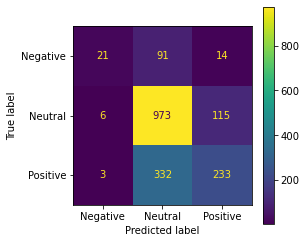

In [103]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
# Plot the Confusion Matrix with a smaller size
fig, ax = plt.subplots(figsize=(4, 4))  
ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels= rf_best_model.classes_).plot(ax=ax)

# Show the plot
plt.show()

# Features Importance Analysis

After determining our best model and evaluating it on the test set, we looked at its feature importance and compared this the td-idf frequencies for each words by sentiment. This way, we can attempt to draw some conclusions and recommendations based on which words are most preditictive of sentiment in our model, and if they are associated with positive sentiment in tweets or negative sentiment in tweets.

## Multiclass Random Forest Feature Importance

In [104]:
rf_tfidf_vectorizer = rf_best_model.named_steps['tfidf']
rf_tfidf_feature_names = rf_tfidf_vectorizer.get_feature_names()
rf_tfidf_feature_importances = rf_tfidf_vectorizer.idf_

In [105]:
rf_model = rf_best_model.named_steps['rf']
rf_feature_importances = rf_model.feature_importances_

In [106]:
feature_importance_df = pd.DataFrame({'Feature': rf_tfidf_feature_names, 'Importance': rf_feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df.head(50)) 

        Feature  Importance
3155       ipad    0.022421
281       apple    0.011988
1277       cool    0.011718
2602      great    0.011281
274         app    0.010184
2556     google    0.010015
3159     iphone    0.008929
3596       love    0.008379
451     awesome    0.008015
5781      store    0.007938
210         amp    0.007238
403      austin    0.006622
4055        new    0.006599
2550       good    0.006485
5520      smart    0.005864
2493        get    0.005774
3416     launch    0.005674
4597        pop    0.005592
2010       even    0.004706
6757        win    0.004659
6830        wow    0.004551
1042     circle    0.004440
4224        one    0.004388
6203      today    0.004302
4239       open    0.004061
5279        see    0.003997
2531         go    0.003993
5576     social    0.003976
6180       time    0.003760
3517       line    0.003735
3506       like    0.003735
2397        fun    0.003705
223     android    0.003699
4079       nice    0.003677
6553        via    0

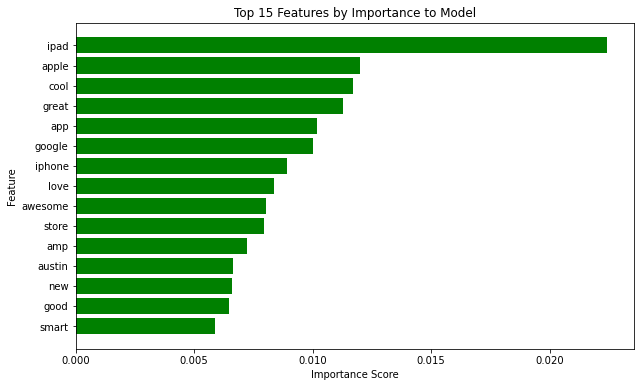

In [107]:
# Get the top 15 features and their importance scores
top_features = feature_importance_df.head(15)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='green')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 15 Features by Importance to Model')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest importance at the top
plt.show()

Some of the words that stand out in terms of feature importance are apple and google, as apple is more predictive of sentiment than google. Store and pop also appear in the top 15, which makes sense considering Apple opened a temporary pop-up store at SXSW. However, the feature importances do not tell which target the words are more predictive for, whether it is positive, neutral, or negative. In order to find out which of the words that are important features are associated with positive, neutral, or negative sentiment tweets, we will find the TD-IDF scores for each word by tweet sentiment. This will help us determine conclusions and recommendations for our marketing strategy at Apple.

## Word Frequency By Target

In [108]:
# Create a new column in your DataFrame for the preprocessed text

# Need to preprocess our text outside of our pipeline for this analysis

df['preprocessed_text'] = df['tweet_text'].apply(lambda x: doc_preparer(x))

In [109]:
#.loc to create dataframes based on target class

positive_df = df[df['emotions']=='Positive']
neutral_df = df[df['emotions']== 'Neutral']
negative_df = df[df['emotions']=='Negative']

In [110]:
positive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2978 entries, 1 to 9088
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   tweet_text         2978 non-null   object
 1   products           2672 non-null   object
 2   emotions           2978 non-null   object
 3   preprocessed_text  2978 non-null   object
dtypes: object(4)
memory usage: 116.3+ KB


In [111]:
#Getting the tf-idf scores for the
#words in tweets with positive sentiment

pos_documents = positive_df['preprocessed_text']
pos_tfidf_vectorizer = TfidfVectorizer()
pos_tfidf_matrix = pos_tfidf_vectorizer.fit_transform(pos_documents)

pos_feature_names = pos_tfidf_vectorizer.get_feature_names()
pos_feature_names
pos_tfidf_scores = pos_tfidf_matrix.mean(axis=0).A1

pos_tfidf_df = pd.DataFrame({'Word': pos_feature_names, 'Positive TF-IDF Score': pos_tfidf_scores})
pos_tfidf_df = pos_tfidf_df.sort_values(by='Positive TF-IDF Score', ascending=False)

print(pos_tfidf_df.head(50)) 

           Word  Positive TF-IDF Score
1884       ipad               0.051810
165       apple               0.048227
3429      store               0.035139
1514     google               0.034988
1887     iphone               0.029093
158         app               0.024743
2434        new               0.022915
230      austin               0.021643
1469        get               0.020174
2738        pop               0.017853
2526       open               0.016348
2035     launch               0.015894
128     android               0.015218
1496         go               0.014502
4015        win               0.014474
122         amp               0.013966
2092       line               0.013074
3907        via               0.012632
2608      party               0.012402
2521        one               0.012234
678        come               0.011998
613      circle               0.011132
3681       time               0.011027
759        cool               0.010880
1546      great          

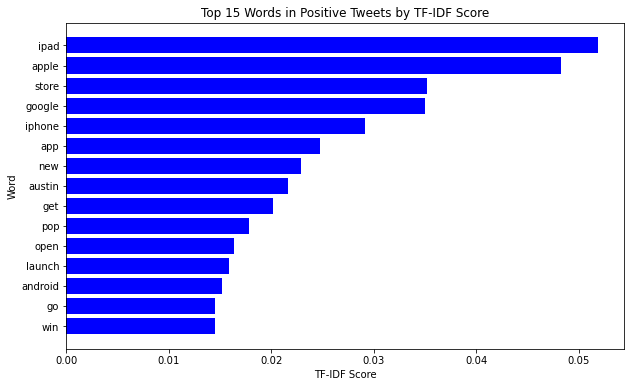

In [112]:
#Graphing the top 15 words in positive tweets
#and their TF-IDF scores

p_top_terms = pos_tfidf_df.head(15)

plt.figure(figsize=(10, 6))
plt.barh(p_top_terms['Word'], p_top_terms['Positive TF-IDF Score'], color='blue')
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.title('Top 15 Words in Positive Tweets by TF-IDF Score')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest score at the top
plt.show()

In [113]:
#Getting the tf-idf scores for the
#words in tweets with neutral sentiment

neut_documents = neutral_df['preprocessed_text']
neut_tfidf_vectorizer = TfidfVectorizer()
neut_tfidf_matrix = neut_tfidf_vectorizer.fit_transform(neut_documents)

neut_feature_names = neut_tfidf_vectorizer.get_feature_names()
neut_tfidf_scores = neut_tfidf_matrix.mean(axis=0).A1

neut_tfidf_df = pd.DataFrame({'Word': neut_feature_names, 'Neutral TF-IDF Score': neut_tfidf_scores})
neut_tfidf_df = neut_tfidf_df.sort_values(by='Neutral TF-IDF Score', ascending=False)

print(neut_tfidf_df.head(50)) 

           Word  Neutral TF-IDF Score
2181     google              0.045073
232       apple              0.041290
2667       ipad              0.040956
4872      store              0.035034
2886     launch              0.026663
3440        new              0.026190
2671     iphone              0.025424
338      austin              0.025278
900      circle              0.024632
4706     social              0.023099
5218      today              0.020048
174         amp              0.019936
3897        pop              0.019434
3435    network              0.019349
3596       open              0.017592
738        call              0.016203
227         app              0.014592
2126        get              0.014498
183     android              0.014397
2971       line              0.014308
5519        via              0.014024
3093      major              0.013674
3922   possibly              0.011961
2162         go              0.011589
2002       free              0.011474
3296     mob

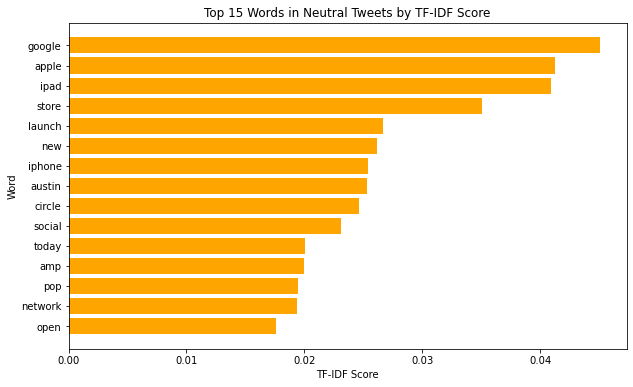

In [114]:
#Graphing the top 15 words in neutral tweets
#and their TF-IDF scores

neutral_top_terms = neut_tfidf_df.head(15)


plt.figure(figsize=(10, 6))
plt.barh(neutral_top_terms['Word'], neutral_top_terms['Neutral TF-IDF Score'], color='orange')
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.title('Top 15 Words in Neutral Tweets by TF-IDF Score')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest score at the top
plt.show()

In [115]:
#Getting the tf-idf scores for the
#words in tweets with negative sentiment

neg_documents = negative_df['preprocessed_text']
neg_tfidf_vectorizer = TfidfVectorizer()
neg_tfidf_matrix = neg_tfidf_vectorizer.fit_transform(neg_documents)

neg_feature_names = neg_tfidf_vectorizer.get_feature_names()
neg_tfidf_scores = neg_tfidf_matrix.mean(axis=0).A1

neg_tfidf_df = pd.DataFrame({'Word': neg_feature_names, 'Negative TF-IDF Score': neg_tfidf_scores})
neg_tfidf_df = neg_tfidf_df.sort_values(by='Negative TF-IDF Score', ascending=False)

print(neg_tfidf_df.head(50)) 

          Word  Negative TF-IDF Score
803       ipad               0.051201
807     iphone               0.042071
660     google               0.039108
76       apple               0.035982
72         app               0.023019
1456     store               0.018800
1017       new               0.016882
242     circle               0.016610
881       like               0.016608
642        get               0.015943
388     design               0.015260
1407    social               0.014395
1008      need               0.013514
80        apps               0.013511
651         go               0.013469
861     launch               0.013144
1111    people               0.012549
1533     think               0.012446
96      austin               0.012027
54     android               0.011446
901       look               0.011415
885       line               0.011273
706   headache               0.010829
1622       use               0.010820
1502      take               0.010468
1545      ti

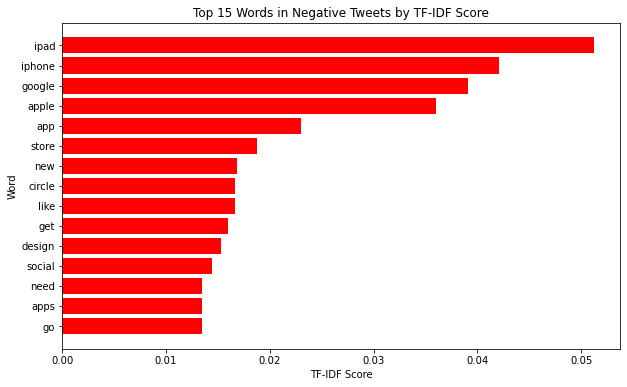

In [116]:
#Graphing the top 15 words in neutral tweets
#and their TF-IDF scores

n_top_terms = neg_tfidf_df.head(15)

plt.figure(figsize=(10, 6))
plt.barh(n_top_terms['Word'], n_top_terms['Negative TF-IDF Score'], color='red')
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.title('Top 15 Words in Negative Tweets by TF-IDF Score')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest score at the top
plt.show()

Focusing on the positive and negative tweets, as these tweets are more pertinent to our marketing strategy, we noticed that Apple is much more prevalent in positive tweets compared to our competitor Google, and Google is more associated with negative sentiment tweets. We also saw that the words Store and pop are more common in positive tweets than negative tweets, likely referring to the temporary pop-up Apple Store at SXSW. We also noticed the word ‘launch’ is more common in positive sentiment tweets, and iPhone seems relatively more frequent in negative tweets than positive.



# Conclusions and Recommendations

Based on the the most important features in our model and their association to positive or negative tweets, we have made some conclusions and recommendations for our marketing strategy going forward.

1. Continue overall marketing strategy, as we are outperforming Google, our competitor, in terms of tweets with positive sentiment. Apple should consider continuing to have a presence with speakers and presentations, as well as with social media interaction with the event.


2. The temporary pop-up store was a success based on the overall positive sentiment on twitter. Therefore, Apple should continuing implementing the pop-up store at SXSW and similar types of events.


3. Because 'Launch' was particularly associated with positive tweets at SXSW, Apple should continue heavily marketing its new and forthcoming products by marketing and showing its launches both at events and on social media. 


4. Address the negative sentiment around iPhone. Apple specifically could look at the tweets with negative sentiment directed at iPhone, and try to address the issues that people have had with the product. For example, iPhone battery seems to have been a common topic among negative tweets about the iPhone. Apple could use information like this to improve its marketing strategy for improved battery technology and performance in the future.